<a href="https://colab.research.google.com/github/palaceIA/CICS_Project/blob/main/src/notebooks/deberta/deberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning DeBERTa Base
Esse jupyter faz parte na nossa pesquisa para o Congresso Internacional (CICS) , aqui você ira encontrar nosso experimento referente ao modelo DeBERTa Base e os nossos devidos resultados. O dataset utlizado foi o "dair-ai/emotion" disponivel no HuggingFace .


## DeBERTa-base

DeBERTa melhora os modelos BERT e RoBERTa usando atenção desemaranhada e decodificador de máscara aprimorado. Ele supera BERT e RoBERTa na maioria das tarefas NLU com 80 GB de dados de treinamento.

link : https://github.com/microsoft/DeBERTa

In [1]:
# Instalando os modulos
!pip install torch transformers datasets matplotlib numpy scikit-learn pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Carregando os modulos

In [2]:
from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    AutoTokenizer,
    AutoModel ,
    Trainer
)
from sklearn.metrics import (
    accuracy_score ,
    f1_score ,
    classification_report ,
    roc_curve ,
    auc
)
from scipy.special import softmax
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

### Carregando o dataset

In [ ]:
id_data = "dair-ai/emotion"
dataset = load_dataset(id_data)

### Entendendo os dados

In [4]:
# Estrutura do dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [5]:
# Total de classes do dataset
classes = dataset['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [6]:
# Alterando o formato do dataset para um tipo pandas
dataset.set_format(type='pandas')
df_pandas = dataset['train'][:]
df_pandas.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
# Criando uma tabela para cada classe correspondente
df_pandas['label_name'] = df_pandas['label'].apply(lambda x : classes[x])
df_pandas.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [8]:
# Verificando o balanceamento das classes
total_classes = df_pandas['label_name'].value_counts()
total_classes

,count
label_name,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


In [9]:
# Resetando o formato original dos dados
dataset.reset_format()

### Carregando o tokenizador do modelo

In [ ]:
id_model = 'microsoft/deberta-base'
tokenizador = AutoTokenizer.from_pretrained(id_model)

In [11]:
# passaremos a quantidade de batchs dos dados
# Para aplicar essas a tokenizaço de todos os dados
# basta usar o metodo map()
# Função para tokenizar o dataset
def tokenizador_lote(batch):
    temp = tokenizador(
        batch['text'],  # Aqui, 'batch' deve ser um dicionário com uma chave 'text'
        padding=True,
        truncation=True,
    )
    return temp


### Tokenizando dados

In [ ]:
dataset_tokenizado = dataset.map(
    tokenizador_lote,
    batched = True ,
    batch_size=None
)

### Carregando modelo

In [ ]:
model= AutoModel.from_pretrained(id_model)

In [14]:
model

DebertaModel(
  (embeddings): DebertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=0)
    (LayerNorm): DebertaLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): DebertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x DebertaLayer(
        (attention): DebertaAttention(
          (self): DisentangledSelfAttention(
            (in_proj): Linear(in_features=768, out_features=2304, bias=False)
            (pos_dropout): Dropout(p=0.1, inplace=False)
            (pos_proj): Linear(in_features=768, out_features=768, bias=False)
            (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): DebertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): DebertaLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): DebertaIntermediate(
 

### Configurações iniciais para o ajuste fino

In [15]:
# Armazenando numero de classes
numero_classes = len(classes)
# Inicializando plataforma CUDA
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
model = AutoModelForSequenceClassification.from_pretrained(
    id_model , num_labels = numero_classes
)


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
device

device(type='cuda')

In [18]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [19]:
!nvidia-smi

Mon Apr  7 17:29:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Configurações do treinamento

In [21]:
# Tamanho do lote
batch_size = 15
model_name = 'deberta-base-emotions'

training_args = TrainingArguments(
    output_dir=model_name ,
    num_train_epochs=4 ,
    learning_rate=1e-5,
    per_device_train_batch_size= batch_size ,
    per_device_eval_batch_size=batch_size ,
    weight_decay=0.01,
    eval_strategy='epoch' ,
    disable_tqdm=False

)

### Conmputação de métricas

In [23]:
def computer_metrics(pred) :
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds,average='weighted')
    acc = accuracy_score(labels,preds)
    return {"acurracy" : acc , "f1" : f1}

### Treinamento

In [24]:
trainer = Trainer(
    model = model ,
    args = training_args ,
    compute_metrics = computer_metrics ,
    train_dataset = dataset_tokenizado['train'] ,
    eval_dataset= dataset_tokenizado['validation'] ,
    tokenizer = tokenizador
)

<ipython-input-24-fe59b000d80f>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [25]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: caiopalacio16 (caiopalacio16-unifsa) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Acurracy,F1
1,0.332900,0.225164,0.926500,0.927431
2,0.200900,0.167686,0.935000,0.935073
3,0.131700,0.173038,0.939000,0.939517
4,0.105500,0.164900,0.944000,0.944253


TrainOutput(global_step=4268, training_loss=0.2557136478441948, metrics={'train_runtime': 1546.8217, 'train_samples_per_second': 41.375, 'train_steps_per_second': 2.759, 'total_flos': 3372677535744000.0, 'train_loss': 0.2557136478441948, 'epoch': 4.0})

### Avaliando modelo

In [26]:
pred_ouptus = trainer.predict(
    dataset_tokenizado['test']
)
pred_ouptus.metrics

{'test_loss': 0.19926083087921143,
 'test_acurracy': 0.924,
 'test_f1': 0.9242508652693447,
 'test_runtime': 10.8458,
 'test_samples_per_second': 184.403,
 'test_steps_per_second': 12.355}

In [27]:
y_pred = np.argmax(
    pred_ouptus.predictions,axis=1
)
y_test = dataset_tokenizado['test'][:]['label']

In [28]:
y_pred[:5]

array([0, 0, 0, 1, 0])

In [29]:
y_test[:5]

[0, 0, 0, 1, 0]

In [30]:
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [31]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     sadness       0.96      0.96      0.96       581
         joy       0.95      0.94      0.94       695
        love       0.80      0.84      0.82       159
       anger       0.91      0.93      0.92       275
        fear       0.89      0.89      0.89       224
    surprise       0.77      0.77      0.77        66

    accuracy                           0.92      2000
   macro avg       0.88      0.89      0.89      2000
weighted avg       0.92      0.92      0.92      2000



In [32]:
report_dict = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
report_dict

{'sadness': {'precision': 0.9603448275862069,
  'recall': 0.9586919104991394,
  'f1-score': 0.9595176571920758,
  'support': 581.0},
 'joy': {'precision': 0.9517543859649122,
  'recall': 0.9366906474820144,
  'f1-score': 0.9441624365482234,
  'support': 695.0},
 'love': {'precision': 0.8012048192771084,
  'recall': 0.8364779874213837,
  'f1-score': 0.8184615384615385,
  'support': 159.0},
 'anger': {'precision': 0.9142857142857143,
  'recall': 0.9309090909090909,
  'f1-score': 0.9225225225225225,
  'support': 275.0},
 'fear': {'precision': 0.8928571428571429,
  'recall': 0.8928571428571429,
  'f1-score': 0.8928571428571429,
  'support': 224.0},
 'surprise': {'precision': 0.7727272727272727,
  'recall': 0.7727272727272727,
  'f1-score': 0.7727272727272727,
  'support': 66.0},
 'accuracy': 0.924,
 'macro avg': {'precision': 0.8821956937830594,
  'recall': 0.8880590086493406,
  'f1-score': 0.8850414283847959,
  'support': 2000.0},
 'weighted avg': {'precision': 0.9246248903834159,
  'reca

In [33]:
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(4)

In [34]:
# Exibe a tabela
print(report_df)

              precision  recall  f1-score   support
sadness          0.9603  0.9587    0.9595   581.000
joy              0.9518  0.9367    0.9442   695.000
love             0.8012  0.8365    0.8185   159.000
anger            0.9143  0.9309    0.9225   275.000
fear             0.8929  0.8929    0.8929   224.000
surprise         0.7727  0.7727    0.7727    66.000
accuracy         0.9240  0.9240    0.9240     0.924
macro avg        0.8822  0.8881    0.8850  2000.000
weighted avg     0.9246  0.9240    0.9243  2000.000


In [35]:
def plot_multiclass_roc(y_true, y_probs, class_names):
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadeiro Positivo')
    plt.title('Curvas ROC por Emoção')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


In [36]:
pred = trainer.predict(dataset_tokenizado['test'])

In [37]:
# Aplica softmax sobre os logits
y_pred_proba = softmax(pred.predictions, axis=1)

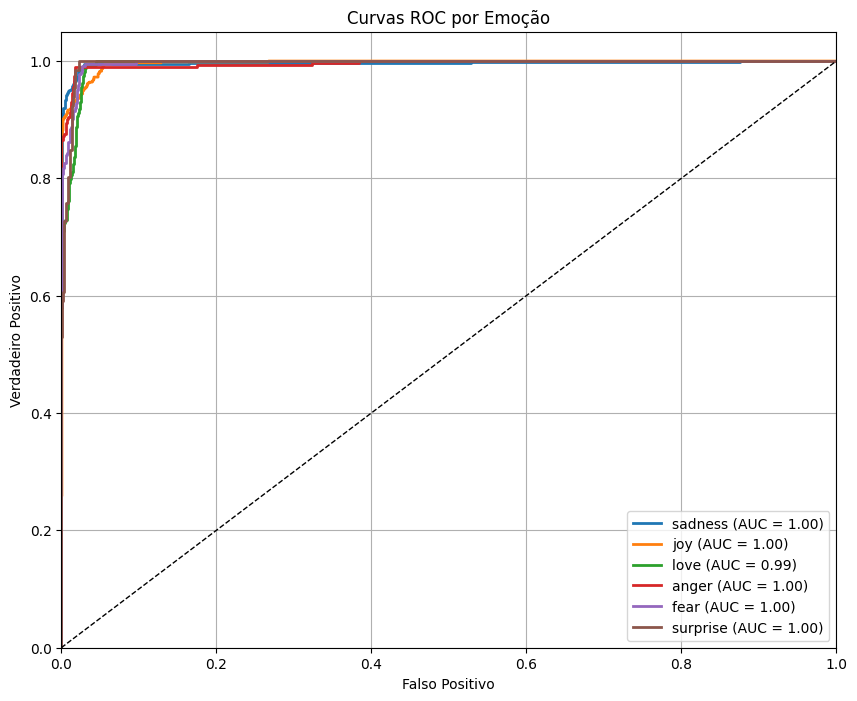

In [38]:
plot_multiclass_roc(y_test, y_pred_proba, classes)

In [39]:
def get_roc_dataframe(y_true, y_probs, class_names):
    n_classes = len(classes)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    dataframes = []

    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)

        df = pd.DataFrame({
            'class': classes[i],
            'fpr': fpr,
            'tpr': tpr,
            'threshold': thresholds,
            'auc': roc_auc  # mesmo valor repetido pra cada linha, pra facilitar agrupamentos
        })

        dataframes.append(df)

    return pd.concat(dataframes, ignore_index=True)

In [40]:
roc_df = get_roc_dataframe(y_test, y_pred_proba,classes)
roc_df

,class,fpr,tpr,threshold,auc
0,sadness,0.000000,0.000000,inf,0.996025
1,sadness,0.000000,0.001721,0.999647,0.996025
2,sadness,0.000000,0.041308,0.999630,0.996025
3,sadness,0.000000,0.046472,0.999629,0.996025
4,sadness,0.000000,0.055077,0.999627,0.996025
...,...,...,...,...,...
653,surprise,0.017063,0.954545,0.064963,0.996005
654,surprise,0.017063,0.984848,0.044071,0.996005
655,surprise,0.022234,0.984848,0.004171,0.996005
656,surprise,0.022234,1.000000,0.004153,0.996005


In [41]:
roc_df.to_csv("curva_roc_por_classe.csv", index=False)